In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import jax.numpy as jnp
from jax import random
import numpyro

from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist

SEED = 99

# Part 1: A Random Walk Model

$$
Y_t = Y_{t-1} + \epsilon_t
$$

where $\epsilon_t$ is an error term with mean 0 and variance $\sigma^2$

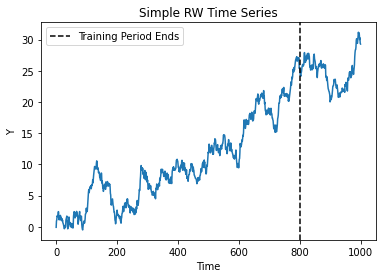

In [2]:
np.random.seed(SEED)
T = 800
h = 200
sigma = 0.5
y = jnp.array( np.random.normal(0, sigma, size=T+h).cumsum() )

fig, ax = plt.subplots()
ax.plot(np.arange(T+h), y)
ax.set(xlabel='Time', ylabel='Y',title='Simple RW Time Series')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()

### Define a model
We're going to start simple, and model the random walk more explicitly. We'll use the scan function, which updates iteratively. The update, or transition function, will simply be `y = y[t-1] + N(0,sigma)`

In [3]:
def rw_model(y, future=0):
    N = y.shape[0]
    level_init = y[0]
    
    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))
    
    def transition_fn(y_t_minus_1, t):
                
        # Observational model
        y_ = numpyro.sample("y", dist.Normal(y_t_minus_1, sigma))
        
        # Recursive update
        y_t_minus_1 = y_
        return y_t_minus_1, y_
    
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, 
            level_init, 
            jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])
    

In [4]:
kernel = NUTS(rw_model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(random.PRNGKey(0), y=y[:800])
mcmc.print_summary()
samples = mcmc.get_samples()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_84253/2470664775.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
sample: 100%|█| 1500/1500 [00:01<00:00, 906.49it/s, 3 steps of size 8.98e-01. ac
sample: 100%|█| 1500/1500 [00:00<00:00, 4455.27it/s, 1 steps of size 1.05e+00. a
sample: 100%|█| 1500/1500 [00:00<00:00, 4392.48it/s, 1 steps of size 9.23e-01. a
sample: 100%|█| 1500/1500 [00:00<00:00, 4439.43it/s, 3 steps of size 1.04e+00. a



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.50      0.01      0.50      0.48      0.52   1580.98      1.00

Number of divergences: 0


<AxesSubplot:ylabel='Count'>

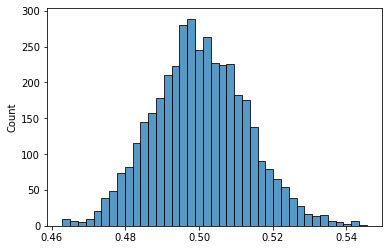

In [5]:
sns.histplot( samples['sigma'] )

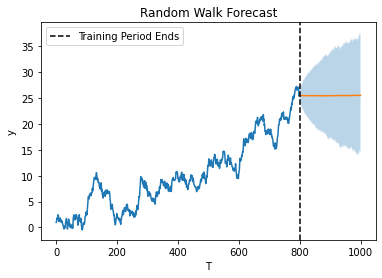

In [6]:
predictive = Predictive(rw_model, samples, return_sites=["y", "y_forecast"])
in_sample = predictive(random.PRNGKey(1), y[:T], future=0)
fcast = predictive(random.PRNGKey(1), y[:T], future=h)
hpd_low, hpd_high = hpdi(fcast['y_forecast'])

fig, ax = plt.subplots()
ax.plot(in_sample['y'].mean(0))
ax.plot(np.arange(T, T+h),fcast ['y_forecast'].mean(0))
ax.fill_between(np.arange(T,T+h), hpd_low, hpd_high, alpha=0.3)
ax.set(xlabel='T', ylabel='y', title='Random Walk Forecast')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()

# Using the Gaussian Random Walk Distribution

In [7]:
def rw_model_simple(y, future=0):
    N = 0 if y is None else y.shape[0]
#     y = jnp.concatenate([y, np.repeat(y[-1:], future)])
    step_size = numpyro.sample("sigma", dist.Exponential(2.5))
    
    
    ys = numpyro.sample(
        "y", dist.GaussianRandomWalk(scale=step_size, num_steps=N+future),
        obs=y
    )
    
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])
       

        

In [8]:
kernel = NUTS(rw_model_simple)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(random.PRNGKey(0), y=y[:T])
mcmc.print_summary()
samples = mcmc.get_samples()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_84253/1224405422.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
sample: 100%|█| 1500/1500 [00:01<00:00, 922.90it/s, 3 steps of size 9.73e-01. ac
sample: 100%|█| 1500/1500 [00:00<00:00, 4711.09it/s, 1 steps of size 1.08e+00. a
sample: 100%|█| 1500/1500 [00:00<00:00, 4410.97it/s, 1 steps of size 9.90e-01. a
sample: 100%|█| 1500/1500 [00:00<00:00, 4475.34it/s, 3 steps of size 9.98e-01. a


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.50      0.01      0.50      0.48      0.52   1598.14      1.00

Number of divergences: 0


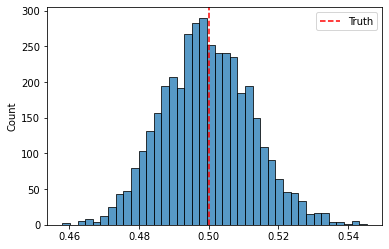

In [9]:
sns.histplot(samples['sigma'])
plt.axvline(sigma, label='Truth', color='r',ls='--')
plt.legend()

In [10]:
predictive = Predictive(rw_model_simple, samples, return_sites=["y", "y_forecast"])
fcast = predictive(random.PRNGKey(1), y=None, future=200)
in_sample = predictive(random.PRNGKey(1), y[:T], future=0)

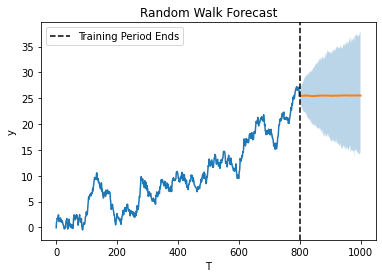

In [11]:

last_value = y[T-1]
hpd_low, hpd_high = hpdi(last_value + fcast['y_forecast'])
y_pred = last_value+fcast['y_forecast'].mean(0)

fig, ax = plt.subplots()
ax.plot(np.arange(T), in_sample['y'].mean(0)[:T])
ax.plot(np.arange(T,T+h), y_pred, lw=2)
ax.fill_between(np.arange(T,T+h), hpd_low, hpd_high, alpha=0.3)
ax.set(xlabel='T', ylabel='y', title='Random Walk Forecast')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()


# Adding Complexity: RW with Drift


$$
Y_t = \alpha + \beta t +  Y_{t-1} + \epsilon_t
$$


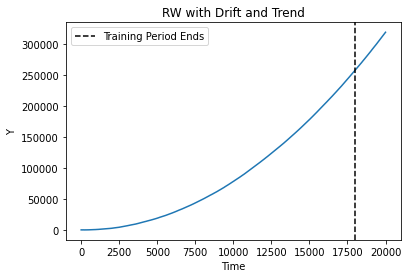

In [12]:
np.random.seed(SEED)
T = 18000
h = 2000

alpha = -0.5
sigma = 5
beta = 0.6

trend = beta*np.arange(T+h)/365.25
rw_with_drift = np.random.normal(alpha+trend, sigma, size=T+h).cumsum() 
y = jnp.array( rw_with_drift )

fig, ax = plt.subplots()
ax.plot(np.arange(T+h), y)
ax.set(xlabel='Time', ylabel='Y',title='RW with Drift and Trend')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()

In [13]:
def rw_with_trend_and_drift_model(y, future=0):
    N = y.shape[0]
    level_init = y[0]
    
    alpha = numpyro.sample("alpha", dist.Normal(0,5))
    beta = numpyro.sample("beta", dist.Normal(0,0.25))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
    def transition_fn(y_t_minus_1, t):
        
        exp_val = y_t_minus_1 + alpha + beta*t/365.25
       
        # Observational model
        y_ = numpyro.sample("y", dist.Normal(exp_val, sigma))
        
        # Recursive update
        y_t_minus_1 = y_
        return y_t_minus_1, y_
    
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, 
            level_init, 
            jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])
    

In [14]:
kernel = NUTS(rw_with_trend_and_drift_model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(random.PRNGKey(0), y=y[:T])
mcmc.print_summary()
samples = mcmc.get_samples()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_84253/314695621.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
sample: 100%|█| 1500/1500 [00:06<00:00, 220.42it/s, 3 steps of size 1.93e-01. ac
sample: 100%|█| 1500/1500 [00:04<00:00, 360.23it/s, 3 steps of size 2.60e-01. ac
sample: 100%|█| 1500/1500 [00:04<00:00, 341.52it/s, 19 steps of size 2.21e-01. a
sample: 100%|█| 1500/1500 [00:04<00:00, 320.70it/s, 15 steps of size 1.91e-01. a


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.27      0.08     -0.27     -0.41     -0.16   1437.67      1.00
      beta      0.59      0.00      0.59      0.59      0.60   1584.37      1.00
     sigma      5.02      0.03      5.02      4.98      5.07   1958.70      1.00

Number of divergences: 0


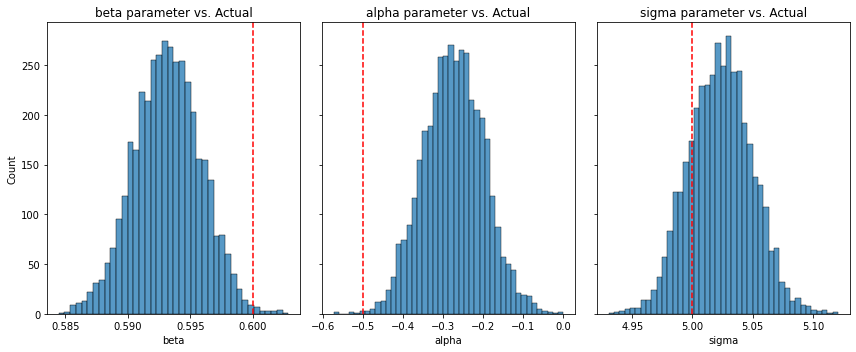

In [15]:
fig, ax = plt.subplots(1,3,figsize=(12,5),sharey=True)

sns.histplot( samples['beta'],ax=ax[0] )
ax[0].axvline(beta, ls='--', color='r')
ax[0].set(title='beta parameter vs. Actual', xlabel='beta')

sns.histplot( samples['alpha'],ax=ax[1] )
ax[1].axvline(alpha, ls='--', color='r')
ax[1].set(title='alpha parameter vs. Actual', xlabel='alpha')


sns.histplot( samples['sigma'],ax=ax[2] )
ax[2].axvline(sigma, ls='--', color='r')
ax[2].set(title='sigma parameter vs. Actual', xlabel='sigma')
plt.tight_layout()

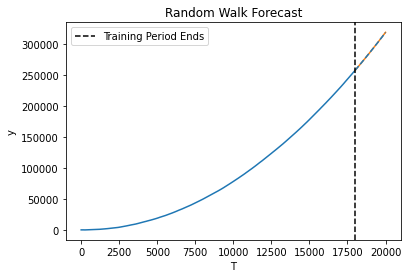

In [16]:
predictive = Predictive(rw_with_trend_and_drift_model, samples, return_sites=["y", "y_forecast"])
in_sample = predictive(random.PRNGKey(1), y[:T], future=0)
fcast = predictive(random.PRNGKey(1), y[:T], future=h)
hpd_low, hpd_high = hpdi(fcast['y_forecast'])

fig, ax = plt.subplots()
ax.plot(in_sample['y'].mean(0))
ax.plot(np.arange(T, T+h), y[T:T+h])

ax.plot(np.arange(T, T+h),fcast ['y_forecast'].mean(0), color='C0',ls='--')
ax.fill_between(np.arange(T,T+h), hpd_low, hpd_high, alpha=0.3)
ax.set(xlabel='T', ylabel='y', title='Random Walk Forecast')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()

# Multivariate Time Series Forecasting

We're going to simulate 100 different time series from a RW with drift and trend formulation.

The sigma parameter will be similar among time series, however the drift and trend variables will vary more

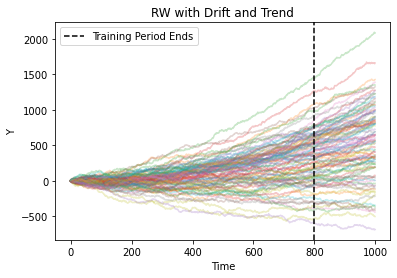

In [17]:
np.random.seed(SEED)
T = 800
h = 200
N = 100


mu_alpha = -0.15
log_mu_sigma = np.log(5)
mu_beta = 0.5


alpha = np.random.normal(mu_alpha, 0.35, size=N)
sigma = np.random.gamma(100, np.exp(log_mu_sigma)/100, size=N)
beta = np.random.normal(mu_beta, 0.25, size=N)

trend = beta[:,None]*np.arange(T+h)/365.25
rw_with_drift = np.random.normal(alpha[:,None]+trend, sigma[:,None]).cumsum(-1) 
y = jnp.array( rw_with_drift  )

fig, ax = plt.subplots()
ax.plot(np.arange(T+h), y.T, alpha=0.25)
ax.set(xlabel='Time', ylabel='Y',title='RW with Drift and Trend')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()

In [18]:
def hierarchical_rw_model(y=None, future=0):
    N = 0 if y is None else y.shape[0]
    T = 0 if y is None else y.shape[1]
    level_init = 0 if y is None else y[:,0]
    
    # Global Vars
    mu_alpha = numpyro.sample("mu_alpha", dist.Normal(0,1))
    sig_alpha = numpyro.sample("sig_alpha", dist.Exponential(2.5))

    mu_beta = numpyro.sample("mu_beta", dist.Normal(0,1))
    sig_beta = numpyro.sample("sig_beta", dist.Exponential(1))

    mu_sigma = numpyro.sample("mu_sigma", dist.Normal(0,1))
    
    # Time Series Level vars
    with numpyro.plate("time_series", N):
        alpha = numpyro.sample("alpha", dist.Normal(mu_alpha,sig_alpha))
        beta = numpyro.sample("beta", dist.Normal(mu_beta, sig_beta))
        sigma = numpyro.sample("sigma", dist.HalfNormal(jnp.exp(mu_sigma)))
    
    def transition_fn(y_t_minus_1, t):
        exp_val = y_t_minus_1 + alpha + beta*t/365.25
        # Observational model
        y_ = numpyro.sample("y", dist.Normal(exp_val, sigma))
        
        # Recursive update
        y_t_minus_1 = y_
        return y_t_minus_1, y_
    
    # It seems like condition+scan may only work along the first axis,
    # so transposing y
    with numpyro.handlers.condition(data={"y": y[:,1:].T}):
        _, ys = scan(
            f=transition_fn, 
            init=level_init, 
            xs=jnp.arange(1, T + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])
    

In [19]:
kernel = NUTS(hierarchical_rw_model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2)
mcmc.run(random.PRNGKey(0), y=y[...,:T])
# mcmc.print_summary()
samples = mcmc.get_samples()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_84253/90730866.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2)
sample: 100%|█| 1500/1500 [00:20<00:00, 71.56it/s, 15 steps of size 2.50e-01. ac
sample: 100%|█| 1500/1500 [00:22<00:00, 67.48it/s, 31 steps of size 2.23e-01. ac


### Looking at Parameters

In [20]:
coords = {"time_series":np.arange(100)}
dims = {"alpha":["time_series"], 
        "beta":["time_series"],
        "sigma":['time_series']}

idata = az.from_numpyro(
    mcmc, 
    coords=coords,
    dims=dims
)

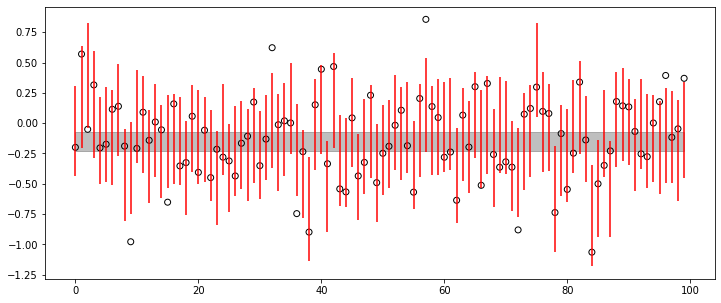

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

bounds =az.hdi( idata )['alpha']
ax.scatter(np.arange(100), alpha, edgecolor='k', facecolor='none' )
ax.vlines(np.arange(100),bounds[:,0], bounds[:,1], edgecolor='r', facecolor='none' )

mu_bounds=az.hdi( idata )['mu_alpha']
ax.fill_between(np.arange(100), mu_bounds[0], mu_bounds[1], alpha=0.25, color='k')



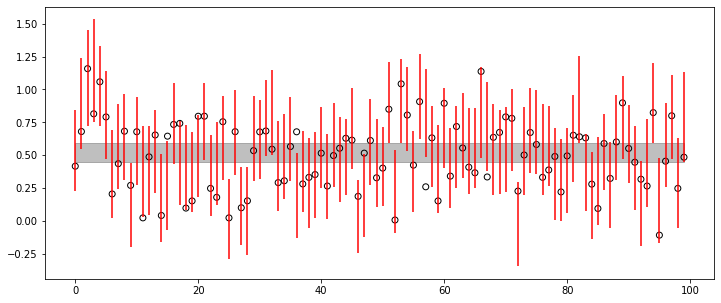

In [22]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

bounds =az.hdi( idata )['beta']
ax.scatter(np.arange(100), beta, edgecolor='k', facecolor='none' )
ax.vlines(np.arange(100), bounds[:,0], bounds[:,1], edgecolor='r', facecolor='none' )

mu_bounds=az.hdi( idata )['mu_beta']
ax.fill_between(np.arange(100), mu_bounds[0], mu_bounds[1], alpha=0.25, color='k')



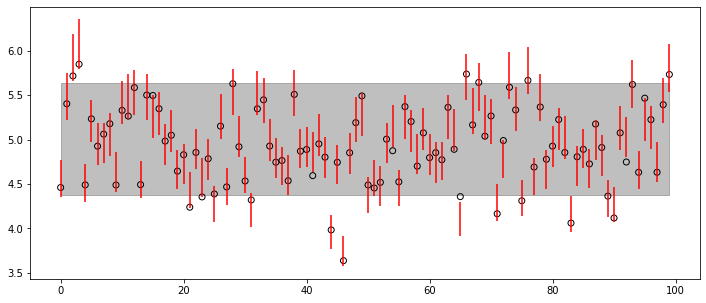

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

bounds =az.hdi( idata )['sigma']
ax.scatter(np.arange(100), sigma, edgecolor='k', facecolor='none' )
ax.vlines(np.arange(100),bounds[:,0], bounds[:,1], edgecolor='r', facecolor='none' )

mu_bounds= np.exp(az.hdi( idata )['mu_sigma'])
ax.fill_between(np.arange(100), mu_bounds[0], mu_bounds[1], alpha=0.25, color='k')



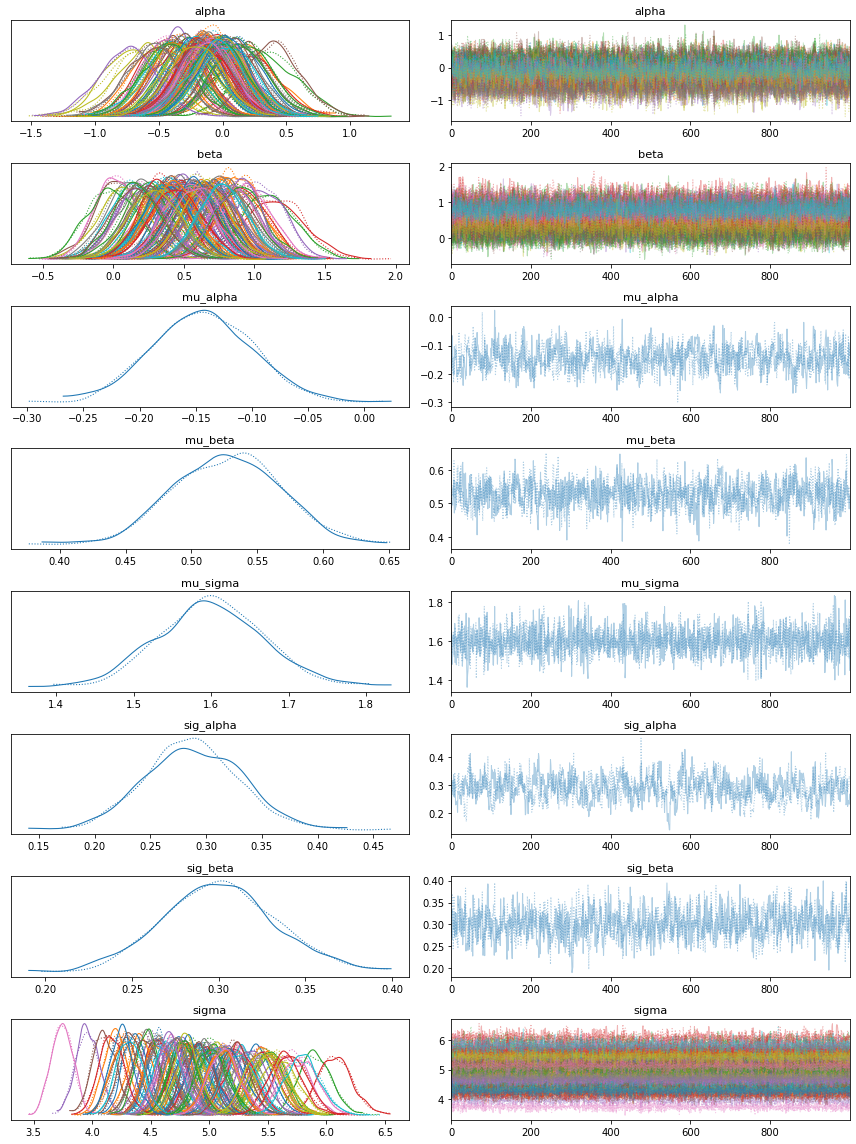

In [24]:
az.plot_trace(idata)
plt.tight_layout()

### Forecasting

In [25]:
predictive = Predictive(hierarchical_rw_model, samples, return_sites=["y", "y_forecast"])
in_sample = predictive(random.PRNGKey(1), y[:,:T], future=0)
fcast = predictive(random.PRNGKey(1), y[:,:T], future=h)
hpd_low, hpd_high = hpdi(fcast['y_forecast'])


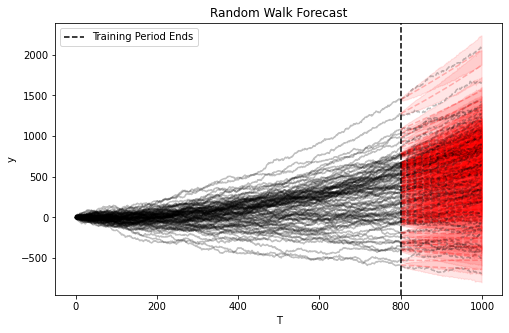

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(in_sample['y'].mean(0), color='k', alpha=0.25)
ax.plot(np.arange(T, T+h), y[:,T:T+h].T, color='k',ls='--', alpha=0.25)

ax.plot(np.arange(T, T+h),fcast['y_forecast'].mean(0), color='r',ls='--', alpha=0.25)

# Could also use the global parameters to show forecast uncertainty across time series
for i in range(100):
    ax.fill_between(np.arange(T,T+h), hpd_low[:,i], hpd_high[:,i], color='r', alpha=0.1)
ax.set(xlabel='T', ylabel='y', title='Random Walk Forecast')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()

This model looks ok, but it may need non-centering to help MCMC sample

# Attempt 2: Non-centering
Numpyro has a cool feature to automatically decenter parameters from a model

In [27]:
from numpyro.infer.reparam import LocScaleReparam

In [28]:
config = {
    "alpha":LocScaleReparam(centered=0),
    "beta":LocScaleReparam(centered=0)
}

nc_hierarchical_rw_model = numpyro.handlers.reparam(
    hierarchical_rw_model, config=config)

In [29]:
kernel = NUTS(nc_hierarchical_rw_model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2)
mcmc.run(random.PRNGKey(0), y=y[...,:T])
# mcmc.print_summary()
samples = mcmc.get_samples()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_84253/3871096220.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2)
sample: 100%|█| 1500/1500 [00:42<00:00, 35.56it/s, 31 steps of size 2.13e-01. ac
sample: 100%|█| 1500/1500 [00:39<00:00, 37.60it/s, 31 steps of size 1.78e-01. ac


In [30]:
idata_nc = az.from_numpyro(
    mcmc, 
    coords=coords,
    dims=dims
)

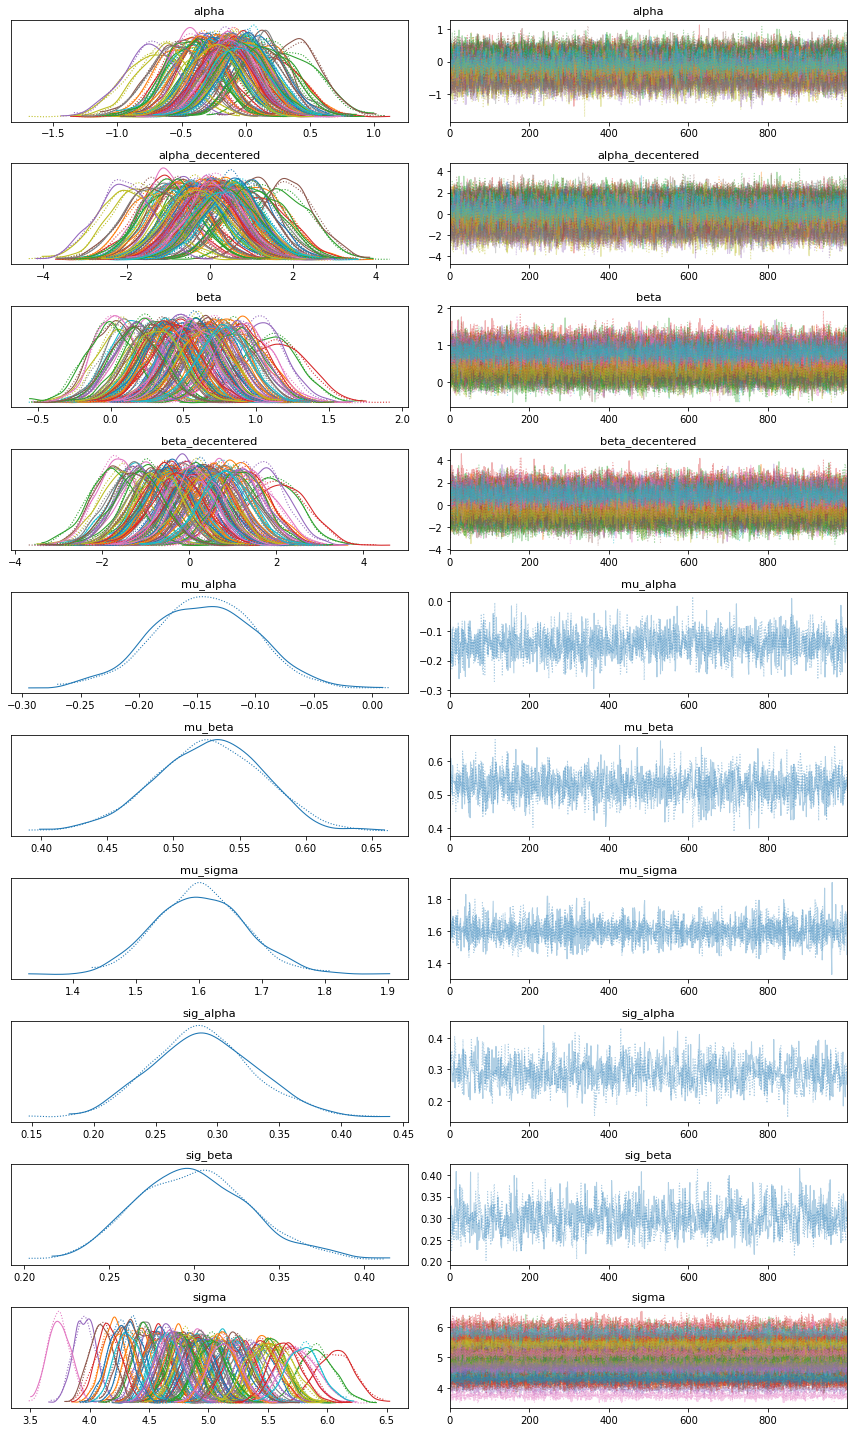

In [31]:
az.plot_trace(idata_nc)
plt.tight_layout()

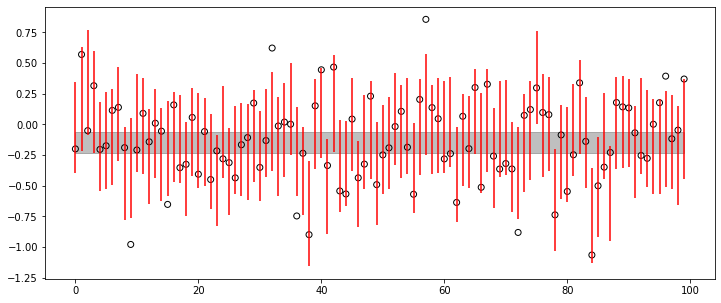

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

bounds =az.hdi( idata_nc )['alpha']
ax.scatter(np.arange(100), alpha, edgecolor='k', facecolor='none' )
ax.vlines(np.arange(100),bounds[:,0], bounds[:,1], edgecolor='r', facecolor='none' )

mu_bounds=az.hdi( idata_nc )['mu_alpha']
ax.fill_between(np.arange(100), mu_bounds[0], mu_bounds[1], alpha=0.25, color='k')



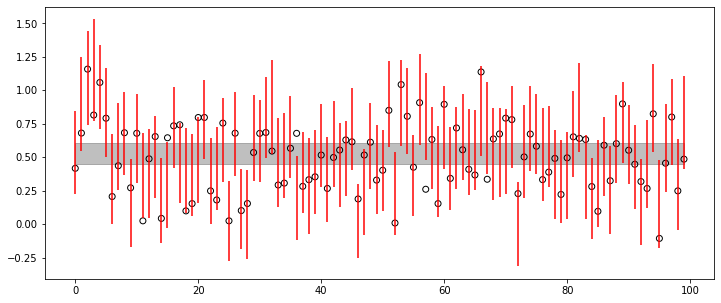

In [33]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

bounds =az.hdi( idata_nc )['beta']
ax.scatter(np.arange(100), beta, edgecolor='k', facecolor='none' )
ax.vlines(np.arange(100), bounds[:,0], bounds[:,1], edgecolor='r', facecolor='none' )

mu_bounds=az.hdi( idata_nc )['mu_beta']
ax.fill_between(np.arange(100), mu_bounds[0], mu_bounds[1], alpha=0.25, color='k')



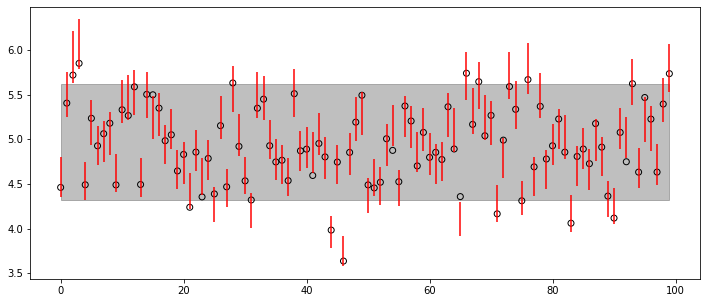

In [34]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

bounds =az.hdi( idata_nc )['sigma']
ax.scatter(np.arange(100), sigma, edgecolor='k', facecolor='none' )
ax.vlines(np.arange(100),bounds[:,0], bounds[:,1], edgecolor='r', facecolor='none' )

mu_bounds= np.exp(az.hdi( idata_nc )['mu_sigma'])
ax.fill_between(np.arange(100), mu_bounds[0], mu_bounds[1], alpha=0.25, color='k')



### Forecasting

In [35]:
predictive = Predictive(nc_hierarchical_rw_model, samples, return_sites=["y", "y_forecast"])
in_sample = predictive(random.PRNGKey(1), y[:,:T], future=0)
fcast = predictive(random.PRNGKey(1), y[:,:T], future=h)
hpd_low, hpd_high = hpdi(fcast['y_forecast'])


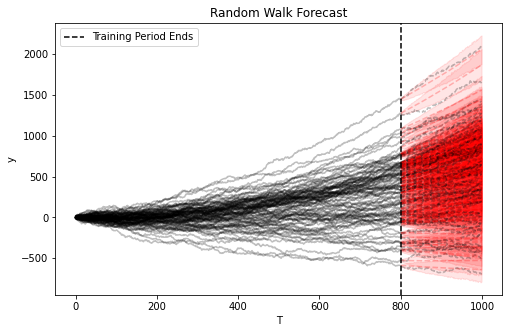

In [36]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(in_sample['y'].mean(0), color='k', alpha=0.25)
ax.plot(np.arange(T, T+h), y[:,T:T+h].T, color='k',ls='--', alpha=0.25)

ax.plot(np.arange(T, T+h),fcast['y_forecast'].mean(0), color='r',ls='--', alpha=0.25)

# Could also use the global parameters to show forecast uncertainty across time series
for i in range(100):
    ax.fill_between(np.arange(T,T+h), hpd_low[:,i], hpd_high[:,i], color='r', alpha=0.1)
ax.set(xlabel='T', ylabel='y', title='Random Walk Forecast')
ax.axvline(T, color='k', ls='--', label='Training Period Ends')
ax.legend()
plt.show()